# Euclid + Planck Fisher Combination

This notebook computes:
1. Euclid spectroscopic Fisher (`GCsp`)
2. Euclid photometric Fisher (`GCph+WL`)
3. Euclid combined Fisher (`GCsp + GCph+WL`)
4. Planck CMB Fisher (`CMB_T`, `CMB_E`)
5. Final combined Fisher (`Euclid + Planck`)

It then plots individual/combined contours and prints 1-sigma tables.

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from IPython.display import display

from cosmicfishpie.fishermatrix import cosmicfish
from cosmicfishpie.analysis import fisher_plot_analysis as cfa
import cosmicfishpie.analysis.fishconsumer as fco

sns.set_theme(context="talk", style="ticks")
snscolors = sns.color_palette("colorblind")

results_dir = Path("./results/notebook_euclid_planck")
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {results_dir.resolve()}")

Results directory: /home/casas/Cosmo/cosmicfishpie/notebooks/results/notebook_euclid_planck


In [2]:
def build_camb_cmb_yaml(base_yaml_path: Path, out_yaml_path: Path) -> Path:
    cfg = yaml.safe_load(base_yaml_path.read_text(encoding="utf-8"))
    cfg.setdefault("COSMO_SETTINGS", {})
    cfg["COSMO_SETTINGS"]["WantCls"] = True
    cfg["COSMO_SETTINGS"]["Want_CMB"] = True
    cfg["COSMO_SETTINGS"]["Want_CMB_lensing"] = False
    cfg["COSMO_SETTINGS"]["Want_cl_2D_array"] = False
    out_yaml_path.write_text(yaml.safe_dump(cfg, sort_keys=False), encoding="utf-8")
    return out_yaml_path


def run_fisher(name, observables, fiducial, freepars, options, specifications={}, survey_name="Euclid"):
    fm = cosmicfish.FisherMatrix(
        fiducialpars=fiducial,
        freepars=freepars,
        options=options,
        specifications=specifications,
        observables=observables,
        cosmoModel=options.get("cosmo_model", "LCDM"),
        surveyName=survey_name,
    )
    fish = fm.compute()
    print(f"Finished {name}: {fish.name}")
    return fish


def sigma_table(fisher, label, params=None):
    par_names = fisher.get_param_names()
    fid = fisher.get_param_fiducial()
    sigmas = fisher.get_confidence_bounds()

    rows = []
    for p, f0, s1 in zip(par_names, fid, sigmas):
        if params is not None and p not in params:
            continue
        pct = np.nan if f0 == 0 else 100.0 * s1 / abs(f0)
        rows.append({"fisher": label, "param": p, "fiducial": f0, "sigma_1s": s1, "percent": pct})

    return pd.DataFrame(rows)

## Common parameter setup

In [3]:
fiducial = {
    "Omegam": 0.32,
    "Omegab": 0.05,
    "h": 0.67,
    "ns": 0.96,
    "sigma8": 0.815584,
    "mnu": 0.06,
    "Neff": 3.044,
}

freepars = {
    "Omegam": 0.01,
    "Omegab": 0.01,
    "h": 0.01,
    "ns": 0.01,
    "sigma8": 0.01,
}

cosmo_params_plot = ["Omegam", "Omegab", "h", "ns", "sigma8"]

## 1) Euclid GCsp Fisher

In [4]:
opts_gcsp = {
    "code": "camb",
    "accuracy": 1,
    "feedback": 1,
    "derivatives": "3PT",
    "results_dir": str(results_dir) + "/",
    "outroot": "nb_euclid_gcsp_",
    "cosmo_model": "LCDM",
    "survey_name": "Euclid",
    "survey_name_photo": False,
    "survey_name_spectro": "Euclid-Spectroscopic-ISTF-Pessimistic",
}

fish_gcsp = run_fisher(
    name="Euclid GCsp",
    observables=["GCsp"],
    fiducial=fiducial,
    freepars=freepars,
    options=opts_gcsp,
    survey_name="Euclid",
)

****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************



  -> Survey loaded:  Euclid-Spectroscopic-ISTF-Pessimistic

  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   4.62 s

In class: FisherMatrix  ----> Computing Pk-spectro Fisher matrix
Computing derivatives of Galaxy Clustering Spectro
>> Computing Derivs >>

  +++ Computing derivative on Omegam



In class: derivatives  Derivative on Omegam done! in :  9.62 s

  +++ Computing derivative on Omegab



In class: derivatives  Derivative on Omegab done! in :  9.63 s

  +++ Computing derivative on h



In class: derivatives  Derivative on h done! in :  10.24 s

  +++ Computing derivative on ns



In class: derivatives  Derivative on ns done! in :  11.01 s

  +++ Computing derivative on sigma8



In class: derivatives  Derivative on sigma8 done! in :  10.89 s

  +++ Computing derivative on lnbg_1

In class: derivatives  Derivative on lnbg_1 done! in :  0.11 s

  +++ Computing derivative on lnbg_2

In class: derivatives  Derivative on lnbg_2 done! in :  0.12 s

  +++ Computing derivative on lnbg_3

In class: derivatives  Derivative on lnbg_3 done! in :  0.12 s

  +++ Computing derivative on lnbg_4

In class: derivatives  Derivative on lnbg_4 done! in :  0.11 s
ððð Obtaining analytical derivative for parameter:  Ps_1
ððð Obtaining analytical derivative for parameter:  Ps_2
ððð Obtaining analytical derivative for parameter:  Ps_3
ððð Obtaining analytical derivative for parameter:  Ps_4

In class: FisherMatrix  Fisher Matrix shape: (4, 13, 13)

In class: FisherMatrix  Fisher Matrix shape: (4, 13, 13)

  Fisher matrix calculation finished in   52.21 s

  Fisher matrix exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_euclid_gcsp__GCsp_FM.txt


In class: FisherMatrix  C

## 2) Euclid Photo Fisher (GCph+WL)

In [5]:
opts_photo = {
    "code": "camb",
    "accuracy": 1,
    "feedback": 1,
    "derivatives": "3PT",
    "results_dir": str(results_dir) + "/",
    "outroot": "nb_euclid_photo_",
    "cosmo_model": "LCDM",
    "survey_name": "Euclid",
    "survey_name_photo": "Euclid-Photometric-ISTF-Pessimistic",
    "survey_name_spectro": False,
}

fish_photo = run_fisher(
    name="Euclid Photo (GCph+WL)",
    observables=["GCph", "WL"],
    fiducial=fiducial,
    freepars=freepars,
    options=opts_photo,
    survey_name="Euclid",
)

****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************



  -> Survey loaded:  Euclid-Photometric-ISTF-Pessimistic

  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   4.62 s

In class: FisherMatrix  ----> Computing photo Fisher matrix



Computing fiducial



Fiducial generated in 0.44 s

Noise added to fiducial

Noisy Cls generated in 0.00 s

Computed covariance matrix

Covmat of Cls generated in 0.39 s

Total calculation in 0.83 s
>> computing derivs >>

  +++ Computing derivative on Omegam



In class: derivatives  Derivative on Omegam done! in :  11.14 s

  +++ Computing derivative on Omegab



In class: derivatives  Derivative on Omegab done! in :  11.51 s

  +++ Computing derivative on h



In class: derivatives  Derivative on h done! in :  11.82 s

  +++ Computing derivative on ns



In class: derivatives  Derivative on ns done! in :  11.52 s

  +++ Computing derivative on sigma8



In class: derivatives  Derivative on sigma8 done! in :  11.37 s

  +++ Computing derivative on b1

In class: derivatives  Derivative on b1 done! in :  0.81 s

  +++ Computing derivative on b2

In class: derivatives  Derivative on b2 done! in :  0.81 s

  +++ Computing derivative on b3

In class: derivatives  Derivative on b3 done! in :  0.79 s

  +++ Computing derivative on b4

In class: derivatives  Derivative on b4 done! in :  0.80 s

  +++ Computing derivative on b5

In class: derivatives  Derivative on b5 done! in :  0.87 s

  +++ Computing derivative on b6

In class: derivatives  Derivative on b6 done! in :  0.83 s

  +++ Computing derivative on b7

In class: derivatives  Derivative on b7 done! in :  0.83 s

  +++ Computing derivative on b8

In class: derivatives  Derivative on b8 done! in :  0.82 s

  +++ Computing derivative on b9

In class: derivatives  Derivative on b9 done! in :  0.80 s

  +++ Computing derivative on b10

In class: derivatives  Derivative on b10 done! in :  

## 3) Euclid combined Fisher and Euclid-only plots

----
Fisher Name:  CosmicFish_v1.3.0_nb_euclid_gcsp__GCsp_FM
Fisher FoM in Omegam,Omegab: 165686.087
Parameter Omegam    , fiducial:    0.320, 1-sigma error:   0.0047, percent error:      1.5%
Parameter Omegab    , fiducial:    0.050, 1-sigma error:   0.0013, percent error:      2.6%
Parameter h         , fiducial:    0.670, 1-sigma error:   0.0105, percent error:      1.6%
Parameter ns        , fiducial:    0.960, 1-sigma error:   0.0090, percent error:      0.9%
Parameter sigma8    , fiducial:    0.816, 1-sigma error:   0.0063, percent error:      0.8%
Parameter lnbg_1    , fiducial:    0.379, 1-sigma error:   0.0094, percent error:      2.5%
Parameter lnbg_2    , fiducial:    0.474, 1-sigma error:   0.0094, percent error:      2.0%
Parameter lnbg_3    , fiducial:    0.558, 1-sigma error:   0.0094, percent error:      1.7%
Parameter lnbg_4    , fiducial:    0.641, 1-sigma error:   0.0094, percent error:      1.5%
Parameter Ps_1      , fiducial:    0.000, 1-sigma error:  30.6417, perc

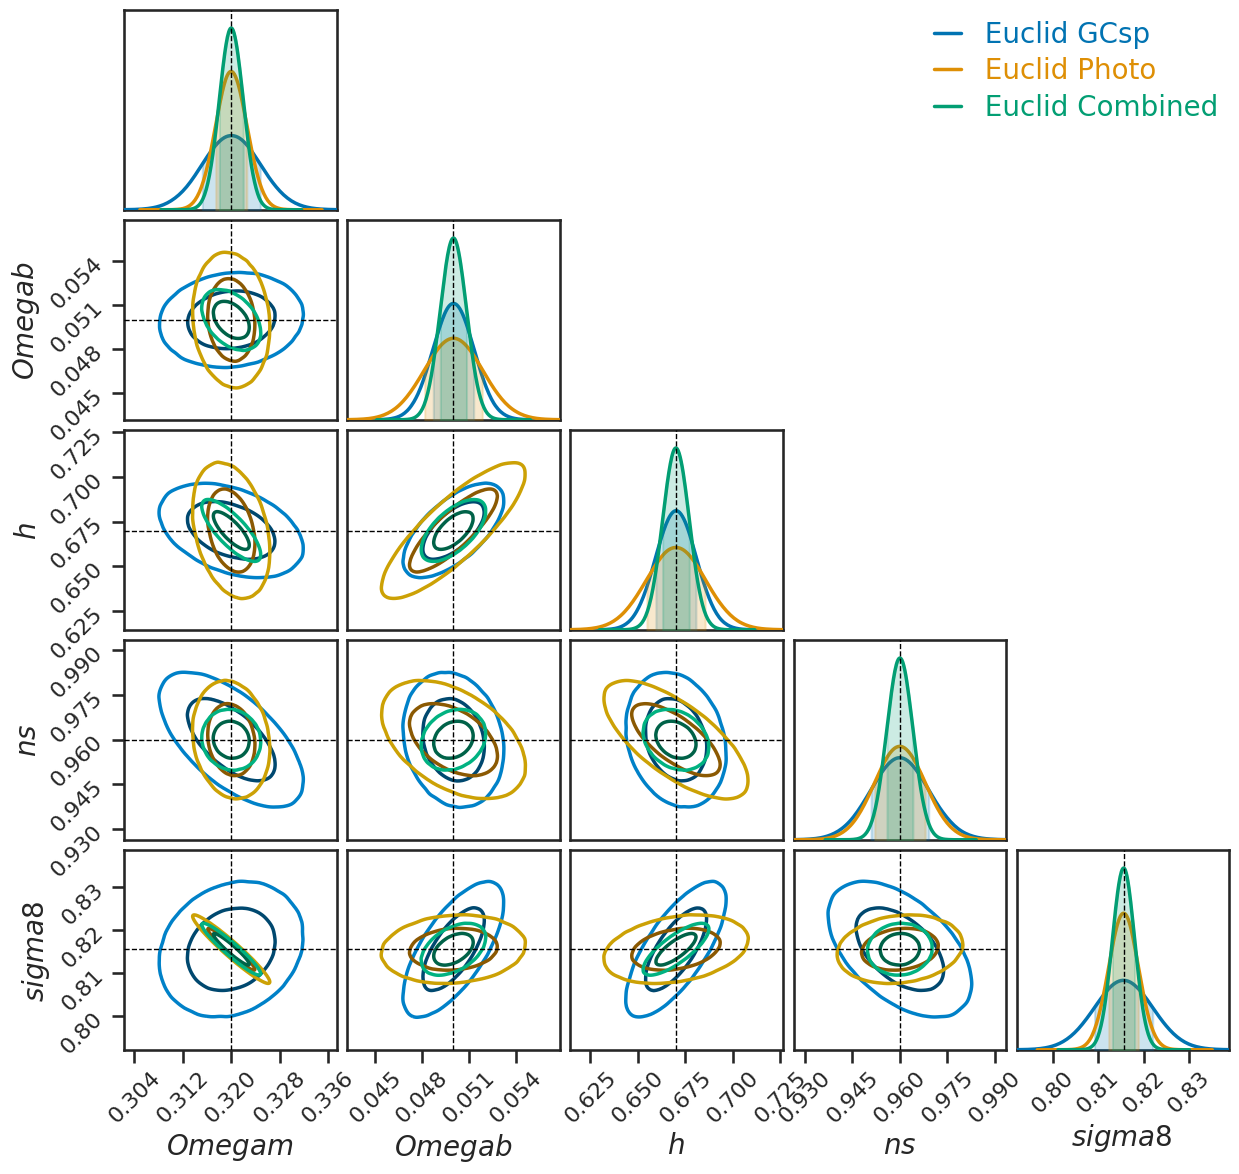

In [6]:
fish_euclid = fish_gcsp + fish_photo
fish_euclid.name = "Euclid_GCsp+Photo"

euclid_list = [fish_gcsp, fish_photo, fish_euclid]
euclid_labels = ["Euclid GCsp", "Euclid Photo", "Euclid Combined"]

euclid_analysis = cfa.CosmicFish_FisherAnalysis(fisher_list=euclid_list)
euclid_analysis.compare_fisher_results()

truth_vals = fish_euclid.get_param_names_fiducial_dict()
param_labels = {p: f"${p}$" for p in cosmo_params_plot}

_ = fco.make_triangle_plot(
    fishers=euclid_list,
    fisher_labels=euclid_labels,
    params=cosmo_params_plot,
    colors=snscolors[:3],
    truth_values=truth_vals,
    smooth=3,
    bins=30,
    param_labels=param_labels,
    savefile=str(results_dir / "euclid_gcsp_photo_combined_triangle.png"),
)

## 4) Planck CMB Fisher (CAMB backend, Legacy/Knox noise)

This section supports two CMB noise prescriptions:
- `legacy`: historical CosmicFishPie CMB noise implementation.
- `knox`: paper-consistent Knox-style noise model (`N_ell = w^{-1} b_ell^{-2}`).

Default below is `knox`.

Note: using observables `["CMB_T", "CMB_E"]` includes the full T/E block (TT, TE, EE) over the selected multipole range.

In [ ]:
from importlib import resources

cfg_dir = resources.files("cosmicfishpie") / "configs"

spec_planck_path = cfg_dir / "default_survey_specifications" / "Planck.yaml"
spec_planck_base = yaml.safe_load(spec_planck_path.read_text(encoding="utf-8"))["specifications"]

# --- User-facing Planck CMB controls ---
# Noise model: "knox" (recommended) or "legacy"
PLANCK_NOISE_MODEL = "knox"
# Optional low-ell EE noise boost (used with Knox mode; harmless in legacy mode)
PLANCK_EE_LOWELL_NOISE_BOOST = 8.0
PLANCK_EE_LOWELL_MAX_ELL = 29
# Multipole range for the full Planck run (inclusive bounds)
PLANCK_ELLMIN = 2
PLANCK_ELLMAX = 1500
# Advanced split run: high(TT+TE+EE) + lowTT + lowEE

base_camb_yaml = cfg_dir / "default_boltzmann_yaml_files" / "camb" / "default.yaml"
camb_cmb_yaml = build_camb_cmb_yaml(base_camb_yaml, results_dir / "camb_cmb_enabled.yaml")

def make_planck_spec(lmin_inclusive: int, lmax_inclusive: int):
    spec = dict(spec_planck_base)
    spec["lmin_CMB"] = int(lmin_inclusive)
    # CMB internals use half-open ell range [lmin, lmax).
    spec["lmax_CMB"] = int(lmax_inclusive) + 1
    spec["CMB_noise_model"] = PLANCK_NOISE_MODEL
    spec["CMB_EE_noise_boost_lowell"] = float(PLANCK_EE_LOWELL_NOISE_BOOST)
    spec["CMB_EE_noise_boost_lmax"] = int(PLANCK_EE_LOWELL_MAX_ELL)
    return spec

opts_planck_common = {
    "code": "camb",
    "camb_config_yaml": str(camb_cmb_yaml),
    "accuracy": 1,
    "feedback": 1,
    "derivatives": "3PT",
    "results_dir": str(results_dir) + "/",
    "cosmo_model": "LCDM",
    "survey_name": "Euclid",
    "survey_name_photo": False,
    "survey_name_spectro": False,
}

spec_planck_full = make_planck_spec(PLANCK_ELLMIN, PLANCK_ELLMAX)
opts_planck_full = {**opts_planck_common, "outroot": f"nb_planck_cmb_full_{PLANCK_NOISE_MODEL}_"}
fish_planck_full = run_fisher(
    name=f"Planck CMB full ({PLANCK_NOISE_MODEL})",
    observables=["CMB_T", "CMB_E"],
    fiducial=fiducial,
    freepars=freepars,
    options=opts_planck_full,
    specifications=spec_planck_full,
    survey_name="Euclid",
)

# Backward-compatible alias used later in notebook cells.
fish_planck = fish_planck_full


****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************



  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   3.66 s

In class: FisherMatrix  ----> Computing CMB Fisher matrix

Computing fiducial

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.70 s
***
Numerical specifications: 
z_bins_GCph = [0.001, 0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576, 2.5]
z_bins_WL = [1.000e-03 4.180e-01 5.600e-01 6.780e-01 7.890e-01 9.000e-01 1.019e+00
 1.155e+00 1.324e+00 1.576e+00 2.500e+00]
zm = 0.9
ngamma = 1.5
ngal_sqarmin_GCph = 30
ngal_sqarmin_WL = 30
photo_z_params = {'fout': 0.1, 'co': 1, 'cb': 1, 'sigma_o': 0.05, 'sigma_b': 0.05, 'zo': 0.1, 'zb': 0.0}
fsky_GCph = 0.0
lmax_GCph = 750
lmin_GCph = 10
ellipt_error = 0.3
fsky_WL = 0.0
lmax_WL = 1500
lmin_WL = 10
kmax = 30.0
vary_ph_bias = 0.06
vary_IA_pars = 0.035
ph_bias_model = binned
ph_bias_parametrization = {'binned': {'keystr': 'b', 'generate_bias_keys': True}, 'binned_constant': {'keystr': 'b', 'generate_bias_keys': True}, 'sqrt': {'b0': 1.0}, 'flagship': {'A': 1.0, 'B': 2.5, 'C': 2.8, 'D': 1.6}}
IA_params = {'IA_model': 'eNLA', 'AIA': 1.72, 'betaIA': 2.17, 'etaIA': -0.41}
ngalbin_WL = [35454308.58012684


Computed covariance matrix

Covmat of Cls generated in 0.54 s

Total calculation in 4.24 s
>> computing derivs >>

  +++ Computing derivative on Omegam

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.92 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.66 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegam done! in :  7.58 s

  +++ Computing derivative on Omegab

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.82 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.86 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegab done! in :  7.68 s

  +++ Computing derivative on h

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.97 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.09 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on h done! in :  8.07 s

  +++ Computing derivative on ns

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.96 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.22 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on ns done! in :  8.18 s

  +++ Computing derivative on sigma8

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.29 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.38 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on sigma8 done! in :  8.67 s

In class: CMBCov  -->> Derivatives computed in   40.19 s

In class: FisherMatrix  Computing Fisher matrix

In class: FisherMatrix  Fisher matrix computed

  Fisher matrix calculation finished in   0.01 s

  Finished calculation of Fisher Matrix for ['CMB_T', 'CMB_E']

  Fisher matrix calculation finished in   44.43 s

  Fisher matrix exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_full_knox__CMB_TCMB_E_FM.txt


In class: FisherMatrix  CosmicFish settings and Survey specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_full_knox__CMB_TCMB_E_FM_specs.dat

In class: FisherMatrix  CosmicFish JSON specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_pl

## 5) Final comparison: Euclid, Planck-full, Euclid+Planck-full

This comparison uses the selected noise mode (`PLANCK_NOISE_MODEL`) for the full Planck CMB run.

----
Fisher Name:  Euclid_GCsp+Photo
Fisher FoM in Omegam,Omegab: 685953.780
Parameter Omegam    , fiducial:    0.320, 1-sigma error:   0.0019, percent error:      0.6%
Parameter Omegab    , fiducial:    0.050, 1-sigma error:   0.0008, percent error:      1.7%
Parameter h         , fiducial:    0.670, 1-sigma error:   0.0069, percent error:      1.0%
Parameter ns        , fiducial:    0.960, 1-sigma error:   0.0041, percent error:      0.4%
Parameter sigma8    , fiducial:    0.816, 1-sigma error:   0.0024, percent error:      0.3%
Parameter lnbg_1    , fiducial:    0.379, 1-sigma error:   0.0038, percent error:      1.0%
Parameter lnbg_2    , fiducial:    0.474, 1-sigma error:   0.0038, percent error:      0.8%
Parameter lnbg_3    , fiducial:    0.558, 1-sigma error:   0.0038, percent error:      0.7%
Parameter lnbg_4    , fiducial:    0.641, 1-sigma error:   0.0038, percent error:      0.6%
Parameter Ps_1      , fiducial:    0.000, 1-sigma error:  25.1561, percent error:      inf%
Par

fisher,Euclid (GCsp+Photo),Euclid+Planck full,"Planck full (T,E) [knox]"
param,,,
Omegam,1.934998742E-03,5.652491103E-04,7.160023351E-03
Omegab,8.252206100E-04,1.406868271E-04,5.743721861E-04
h,6.889463485E-03,7.239607294E-04,5.067742665E-03
ns,4.051250028E-03,1.767377733E-03,3.306729623E-03
sigma8,2.405858639E-03,5.845725385E-04,4.443179136E-03


Percent errors (%):


fisher,Euclid (GCsp+Photo),Euclid+Planck full,"Planck full (T,E) [knox]"
param,,,
Omegam,6.046871070E-01,1.766403470E-01,2.237507297E+00
Omegab,1.650441220E+00,2.813736542E-01,1.148744372E+00
h,1.028278132E+00,1.080538402E-01,7.563795023E-01
ns,4.220052112E-01,1.841018472E-01,3.444510024E-01
sigma8,2.949860026E-01,7.167533184E-02,5.447849806E-01


Saved sigma table to: results/notebook_euclid_planck/euclid_planck_full_sigma_table.csv


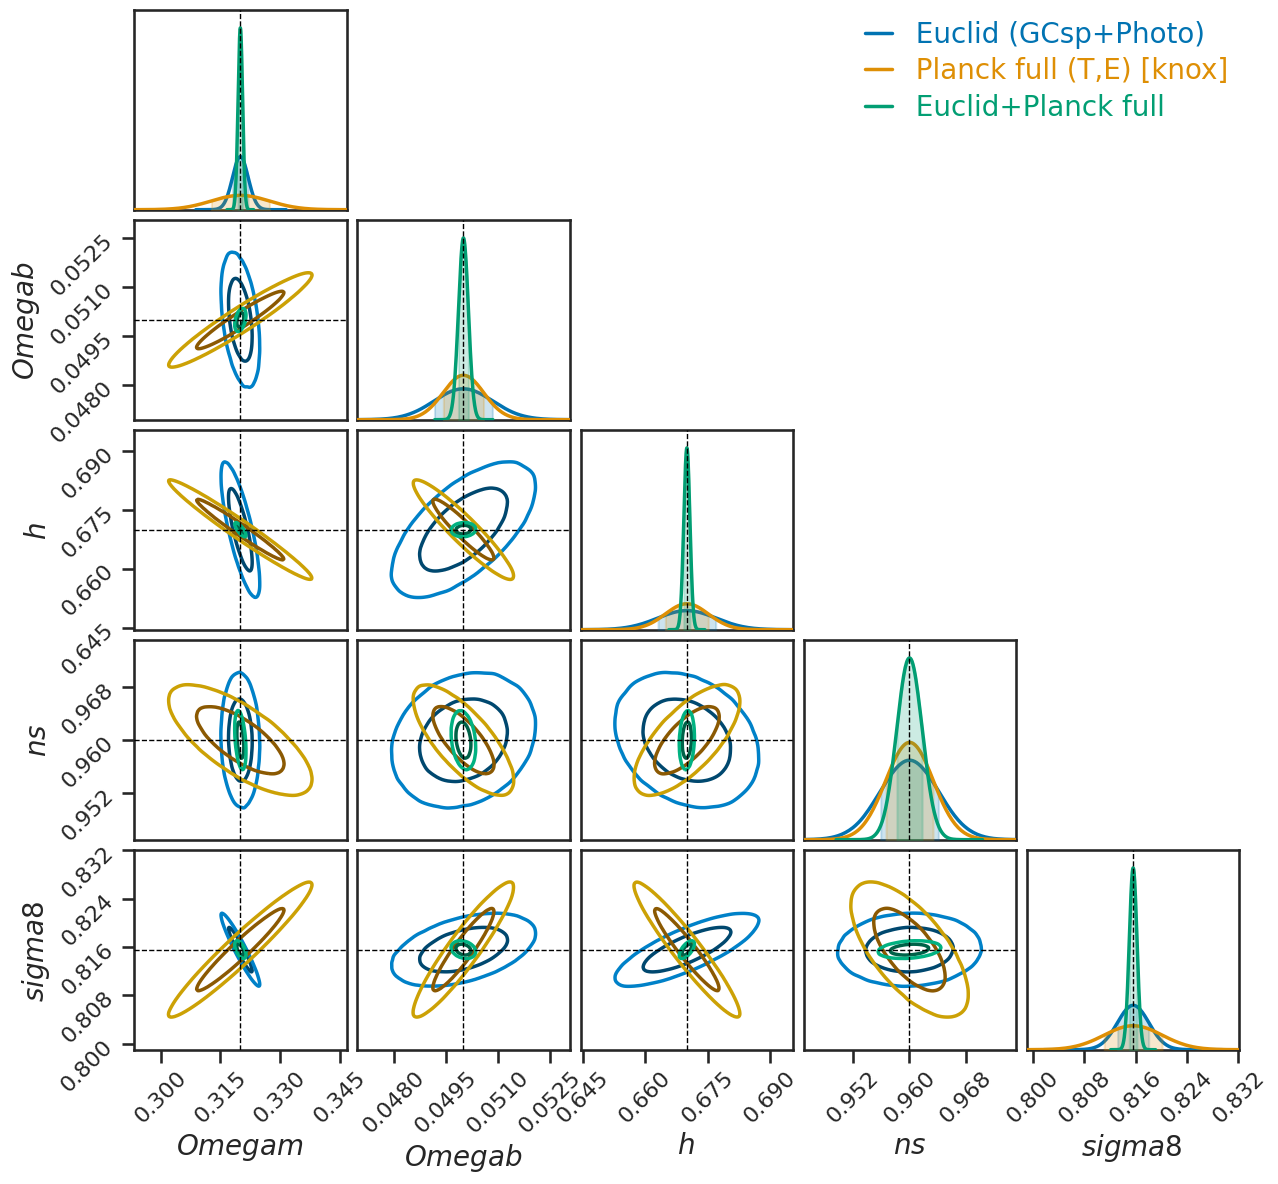

In [8]:
fish_euclid_planck_full = fish_euclid + fish_planck_full
fish_euclid_planck_full.name = f"Euclid+Planck_full_{PLANCK_NOISE_MODEL}"

planck_full_label = f"Planck full (T,E) [{PLANCK_NOISE_MODEL}]"
final_list = [fish_euclid, fish_planck_full, fish_euclid_planck_full]
final_labels = ["Euclid (GCsp+Photo)", planck_full_label, "Euclid+Planck full"]

final_analysis = cfa.CosmicFish_FisherAnalysis(fisher_list=final_list)
final_analysis.compare_fisher_results()

truth_vals_final = fish_euclid_planck_full.get_param_names_fiducial_dict()
param_labels_final = {p: f"${p}$" for p in cosmo_params_plot}

_ = fco.make_triangle_plot(
    fishers=final_list,
    fisher_labels=final_labels,
    params=cosmo_params_plot,
    colors=snscolors[:3],
    truth_values=truth_vals_final,
    smooth=3,
    bins=30,
    param_labels=param_labels_final,
    savefile=str(results_dir / "euclid_planck_full_triangle.png"),
)

sigma_dfs = [
    sigma_table(fish_euclid, "Euclid (GCsp+Photo)", cosmo_params_plot),
    sigma_table(fish_planck_full, planck_full_label, cosmo_params_plot),
    sigma_table(fish_euclid_planck_full, "Euclid+Planck full", cosmo_params_plot),
]
sigma_all = pd.concat(sigma_dfs, ignore_index=True)

print("1-sigma errors by parameter and Fisher:")
display(sigma_all.pivot(index="param", columns="fisher", values="sigma_1s").reindex(cosmo_params_plot))

print("Percent errors (%):")
display(sigma_all.pivot(index="param", columns="fisher", values="percent").reindex(cosmo_params_plot))

sigma_all.to_csv(results_dir / "euclid_planck_full_sigma_table.csv", index=False)
print(f"Saved sigma table to: {results_dir / "euclid_planck_full_sigma_table.csv"}")


## 6) Advanced: 3-part Planck split (lowTT + lowEE + high TTTEEE)

This section compares the advanced split to the full Planck run.
If `PLANCK_RUN_3PART=False` above, this cell prints a reminder and exits.

Split definition:
- lowTT: `CMB_T`, `2..29`
- lowEE: `CMB_E`, `2..29`
- high block (TT+TE+EE): `CMB_T,CMB_E`, `30..ellmax`


In [9]:
# Optional advanced 3-part split (Planck-like low-ell treatment approximation).
PLANCK_RUN_3PART = True
fish_planck_3part = None 
if PLANCK_RUN_3PART:
    spec_high = make_planck_spec(30, PLANCK_ELLMAX)
    spec_low = make_planck_spec(2, 29)

    fish_planck_high = run_fisher(
        name=f"Planck CMB high-l TTTEEE ({PLANCK_NOISE_MODEL})",
        observables=["CMB_T", "CMB_E"],
        fiducial=fiducial,
        freepars=freepars,
        options={**opts_planck_common, "outroot": f"nb_planck_cmb_high_{PLANCK_NOISE_MODEL}_"},
        specifications=spec_high,
        survey_name="Euclid",
    )

    fish_planck_low_t = run_fisher(
        name=f"Planck CMB low-l TT ({PLANCK_NOISE_MODEL})",
        observables=["CMB_T"],
        fiducial=fiducial,
        freepars=freepars,
        options={**opts_planck_common, "outroot": f"nb_planck_cmb_low_t_{PLANCK_NOISE_MODEL}_"},
        specifications=spec_low,
        survey_name="Euclid",
    )

    fish_planck_low_e = run_fisher(
        name=f"Planck CMB low-l EE ({PLANCK_NOISE_MODEL})",
        observables=["CMB_E"],
        fiducial=fiducial,
        freepars=freepars,
        options={**opts_planck_common, "outroot": f"nb_planck_cmb_low_e_{PLANCK_NOISE_MODEL}_"},
        specifications=spec_low,
        survey_name="Euclid",
    )

    fish_planck_3part = fish_planck_high + fish_planck_low_t + fish_planck_low_e
    fish_planck_3part.name = f"Planck_CMB_3part_{PLANCK_NOISE_MODEL}"
    print(f"Built advanced split Fisher: {fish_planck_3part.name}")
else:
    print("PLANCK_RUN_3PART=False: skipping advanced split run in this cell.")



fish_euclid_planck_3part = fish_euclid + fish_planck_3part
fish_euclid_planck_3part.name = f"Euclid+Planck_3part_{PLANCK_NOISE_MODEL}"

advanced_list = [fish_planck_full, fish_planck_3part, fish_euclid_planck_full, fish_euclid_planck_3part]
advanced_labels = [
    f"Planck full [{PLANCK_NOISE_MODEL}]",
    f"Planck 3-part [{PLANCK_NOISE_MODEL}]",
    "Euclid+Planck full",
    "Euclid+Planck 3-part",
]



****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************



  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   3.75 s

In class: FisherMatrix  ----> Computing CMB Fisher matrix

Computing fiducial

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.88 s
***
Numerical specifications: 
z_bins_GCph = [0.001, 0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576, 2.5]
z_bins_WL = [1.000e-03 4.180e-01 5.600e-01 6.780e-01 7.890e-01 9.000e-01 1.019e+00
 1.155e+00 1.324e+00 1.576e+00 2.500e+00]
zm = 0.9
ngamma = 1.5
ngal_sqarmin_GCph = 30
ngal_sqarmin_WL = 30
photo_z_params = {'fout': 0.1, 'co': 1, 'cb': 1, 'sigma_o': 0.05, 'sigma_b': 0.05, 'zo': 0.1, 'zb': 0.0}
fsky_GCph = 0.0
lmax_GCph = 750
lmin_GCph = 10
ellipt_error = 0.3
fsky_WL = 0.0
lmax_WL = 1500
lmin_WL = 10
kmax = 30.0
vary_ph_bias = 0.06
vary_IA_pars = 0.035
ph_bias_model = binned
ph_bias_parametrization = {'binned': {'keystr': 'b', 'generate_bias_keys': True}, 'binned_constant': {'keystr': 'b', 'generate_bias_keys': True}, 'sqrt': {'b0': 1.0}, 'flagship': {'A': 1.0, 'B': 2.5, 'C': 2.8, 'D': 1.6}}
IA_params = {'IA_model': 'eNLA', 'AIA': 1.72, 'betaIA': 2.17, 'etaIA': -0.41}
ngalbin_WL = [35454308.58012684


Computed covariance matrix

Covmat of Cls generated in 0.58 s

Total calculation in 4.46 s
>> computing derivs >>

  +++ Computing derivative on Omegam

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.13 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   3.71 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegam done! in :  7.84 s

  +++ Computing derivative on Omegab

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.01 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.08 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegab done! in :  8.09 s

  +++ Computing derivative on h

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.33 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.08 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on h done! in :  8.41 s

  +++ Computing derivative on ns

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.26 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.18 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on ns done! in :  8.44 s

  +++ Computing derivative on sigma8

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.29 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.21 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on sigma8 done! in :  8.50 s

In class: CMBCov  -->> Derivatives computed in   41.29 s

In class: FisherMatrix  Computing Fisher matrix

In class: FisherMatrix  Fisher matrix computed

  Fisher matrix calculation finished in   0.01 s

  Finished calculation of Fisher Matrix for ['CMB_T', 'CMB_E']

  Fisher matrix calculation finished in   45.76 s

  Fisher matrix exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_high_knox__CMB_TCMB_E_FM.txt


In class: FisherMatrix  CosmicFish settings and Survey specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_high_knox__CMB_TCMB_E_FM_specs.dat

In class: FisherMatrix  CosmicFish JSON specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_pl


  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   4.40 s

In class: FisherMatrix  ----> Computing CMB Fisher matrix

Computing fiducial

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.25 s
***
Numerical specifications: 
z_bins_GCph = [0.001, 0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576, 2.5]
z_bins_WL = [1.000e-03 4.180e-01 5.600e-01 6.780e-01 7.890e-01 9.000e-01 1.019e+00
 1.155e+00 1.324e+00 1.576e+00 2.500e+00]
zm = 0.9
ngamma = 1.5
ngal_sqarmin_GCph = 30
ngal_sqarmin_WL = 30
photo_z_params = {'fout': 0.1, 'co': 1, 'cb': 1, 'sigma_o': 0.05, 'sigma_b': 0.05, 'zo': 0.1, 'zb': 0.0}
fsky_GCph = 0.0
lmax_GCph = 750
lmin_GCph = 10
ellipt_error = 0.3
fsky_WL = 0.0
lmax_WL = 1500
lmin_WL = 10
kmax = 30.0
vary_ph_bias = 0.06
vary_IA_pars = 0.035
ph_bias_model = binned
ph_bias_parametrization = {'binned': {'keystr': 'b', 'generate_bias_keys': True}, 'binned_constant': {'keystr': 'b', 'generate_bias_keys': True}, 'sqrt': {'b0': 1.0}, 'flagship': {'A': 1.0, 'B': 2.5, 'C': 2.8, 'D': 1.6}}
IA_params = {'IA_model': 'eNLA', 'AIA': 1.72, 'betaIA': 2.17, 'etaIA': -0.41}
ngalbin_WL = [35454308.58012684


In class: ComputeCls  ---> Cosmological functions obtained in   4.24 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.12 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegam done! in :  8.37 s

  +++ Computing derivative on Omegab

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.15 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.19 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegab done! in :  8.33 s

  +++ Computing derivative on h

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.37 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.25 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on h done! in :  8.62 s

  +++ Computing derivative on ns

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.18 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.19 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on ns done! in :  8.37 s

  +++ Computing derivative on sigma8

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.12 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.22 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on sigma8 done! in :  8.34 s

In class: CMBCov  -->> Derivatives computed in   42.03 s

In class: FisherMatrix  Computing Fisher matrix

In class: FisherMatrix  Fisher matrix computed

  Fisher matrix calculation finished in   0.00 s

  Finished calculation of Fisher Matrix for ['CMB_T']

  Fisher matrix calculation finished in   46.29 s

  Fisher matrix exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_t_knox__CMB_T_FM.txt


In class: FisherMatrix  CosmicFish settings and Survey specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_t_knox__CMB_T_FM_specs.dat

In class: FisherMatrix  CosmicFish JSON specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_t_kn


  -> Computing cosmology at the fiducial point



  ---> Cosmological functions obtained in:   4.17 s

In class: FisherMatrix  ----> Computing CMB Fisher matrix

Computing fiducial

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.19 s
***
Numerical specifications: 
z_bins_GCph = [0.001, 0.418, 0.56, 0.678, 0.789, 0.9, 1.019, 1.155, 1.324, 1.576, 2.5]
z_bins_WL = [1.000e-03 4.180e-01 5.600e-01 6.780e-01 7.890e-01 9.000e-01 1.019e+00
 1.155e+00 1.324e+00 1.576e+00 2.500e+00]
zm = 0.9
ngamma = 1.5
ngal_sqarmin_GCph = 30
ngal_sqarmin_WL = 30
photo_z_params = {'fout': 0.1, 'co': 1, 'cb': 1, 'sigma_o': 0.05, 'sigma_b': 0.05, 'zo': 0.1, 'zb': 0.0}
fsky_GCph = 0.0
lmax_GCph = 750
lmin_GCph = 10
ellipt_error = 0.3
fsky_WL = 0.0
lmax_WL = 1500
lmin_WL = 10
kmax = 30.0
vary_ph_bias = 0.06
vary_IA_pars = 0.035
ph_bias_model = binned
ph_bias_parametrization = {'binned': {'keystr': 'b', 'generate_bias_keys': True}, 'binned_constant': {'keystr': 'b', 'generate_bias_keys': True}, 'sqrt': {'b0': 1.0}, 'flagship': {'A': 1.0, 'B': 2.5, 'C': 2.8, 'D': 1.6}}
IA_params = {'IA_model': 'eNLA', 'AIA': 1.72, 'betaIA': 2.17, 'etaIA': -0.41}
ngalbin_WL = [35454308.58012684


In class: ComputeCls  ---> Cosmological functions obtained in   4.36 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.20 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegam done! in :  8.57 s

  +++ Computing derivative on Omegab

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.21 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.22 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on Omegab done! in :  8.43 s

  +++ Computing derivative on h

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.13 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.24 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on h done! in :  8.38 s

  +++ Computing derivative on ns

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.25 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.37 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on ns done! in :  8.62 s

  +++ Computing derivative on sigma8

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.40 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: ComputeCls  -> Started Cls calculation



In class: ComputeCls  ---> Cosmological functions obtained in   4.19 s

In class: ComputeCls  -> Computing CMB spectra 

In class: ComputeCls  --> Total Cls computation performed in :   0.00 s

In class: derivatives  Derivative on sigma8 done! in :  8.58 s

In class: CMBCov  -->> Derivatives computed in   42.58 s

In class: FisherMatrix  Computing Fisher matrix

In class: FisherMatrix  Fisher matrix computed

  Fisher matrix calculation finished in   0.00 s

  Finished calculation of Fisher Matrix for ['CMB_E']

  Fisher matrix calculation finished in   46.77 s

  Fisher matrix exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_e_knox__CMB_E_FM.txt


In class: FisherMatrix  CosmicFish settings and Survey specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_e_knox__CMB_E_FM_specs.dat

In class: FisherMatrix  CosmicFish JSON specifications exported: results/notebook_euclid_planck//CosmicFish_v1.3.0_nb_planck_cmb_low_e_kn

In [10]:
sigma_adv = pd.concat(
    [
        sigma_table(fish_planck_full, "Planck full", cosmo_params_plot),
        sigma_table(fish_planck_3part, "Planck 3-part", cosmo_params_plot),
        sigma_table(fish_euclid_planck_full, "Euclid+Planck full", cosmo_params_plot),
        sigma_table(fish_euclid_planck_3part, "Euclid+Planck 3-part", cosmo_params_plot),
    ],
    ignore_index=True,
)
sigma_pivot = sigma_adv.pivot(index="param", columns="fisher", values="sigma_1s").reindex(cosmo_params_plot)
sigma_pivot["Planck 3-part / Planck full"] = sigma_pivot["Planck 3-part"] / sigma_pivot["Planck full"]
sigma_pivot["Euclid+3part / Euclid+full"] = (
    sigma_pivot["Euclid+Planck 3-part"] / sigma_pivot["Euclid+Planck full"]
)
print("Advanced 3-part sigma comparison:")
display(sigma_pivot)

sigma_adv.to_csv(results_dir / "euclid_planck_advanced_3part_sigma_table.csv", index=False)
print(f"Saved advanced sigma table to: {results_dir / "euclid_planck_advanced_3part_sigma_table.csv"}")

Advanced 3-part sigma comparison:


fisher,Euclid+Planck 3-part,Euclid+Planck full,Planck 3-part,Planck full,Planck 3-part / Planck full,Euclid+3part / Euclid+full
param,,,,,,
Omegam,5.652490897E-04,5.652491103E-04,7.160495782E-03,7.160023351E-03,1.000065982E+00,9.999999635E-01
Omegab,1.406866890E-04,1.406868271E-04,5.744057055E-04,5.743721861E-04,1.000058358E+00,9.999990182E-01
h,7.239609776E-04,7.239607294E-04,5.068078052E-03,5.067742665E-03,1.000066181E+00,1.000000343E+00
ns,1.767357913E-03,1.767377733E-03,3.306797235E-03,3.306729623E-03,1.000020447E+00,9.999887856E-01
sigma8,5.845726003E-04,5.845725385E-04,4.443463523E-03,4.443179136E-03,1.000064005E+00,1.000000106E+00


Saved advanced sigma table to: results/notebook_euclid_planck/euclid_planck_advanced_3part_sigma_table.csv


Plot saved to: results/notebook_euclid_planck/euclid_planck_advanced_3part_triangle.png


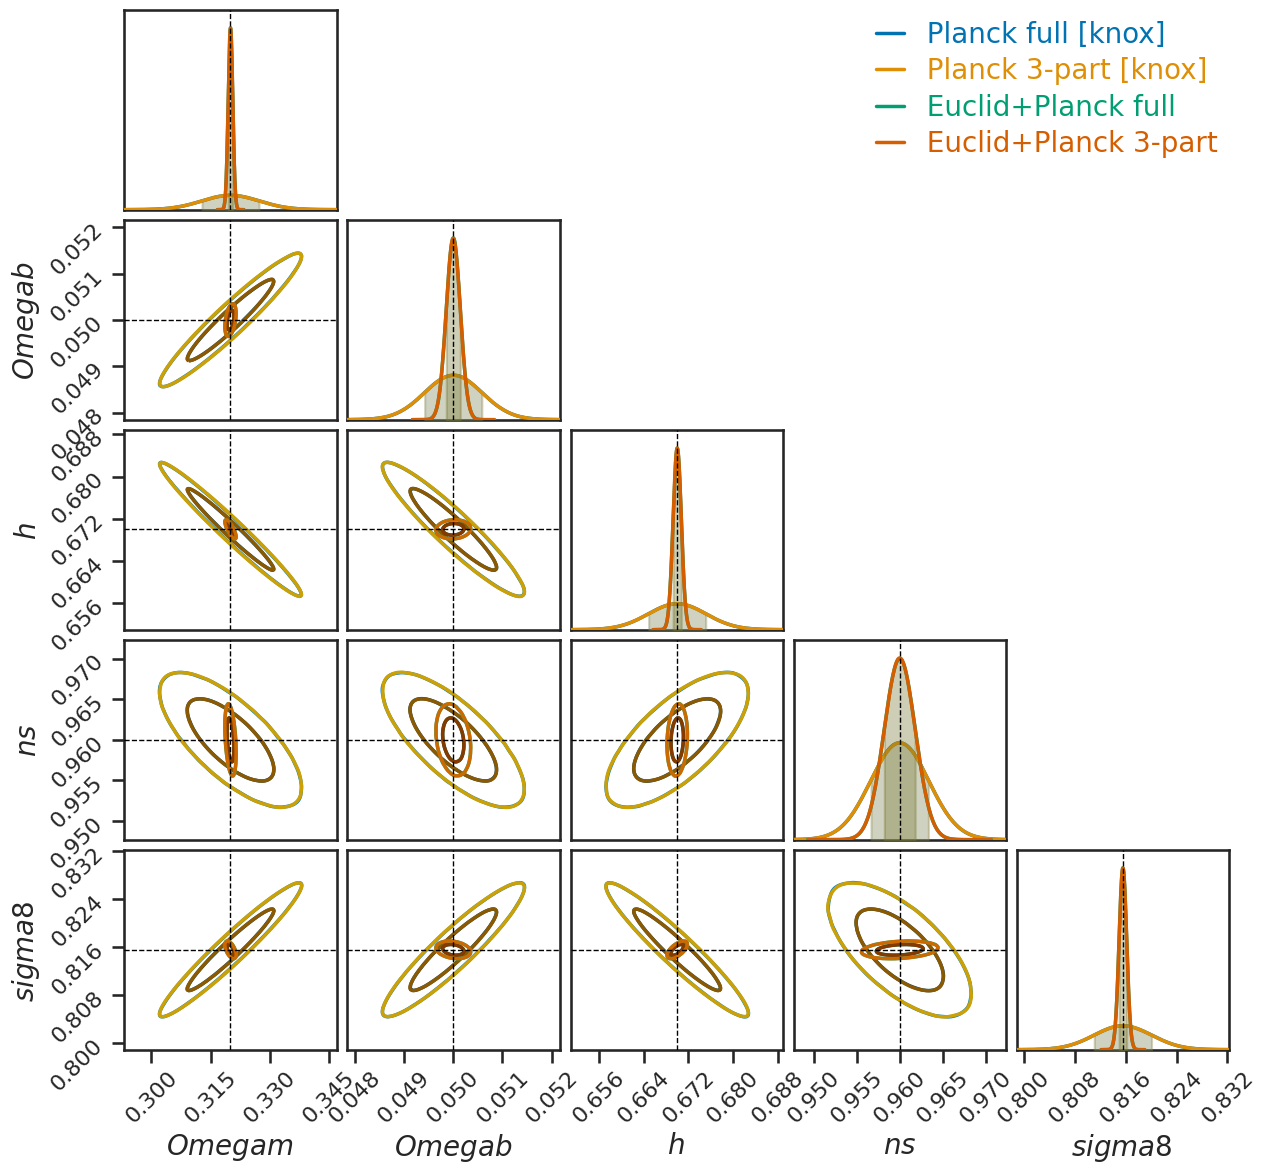

In [11]:

_ = fco.make_triangle_plot(
    fishers=advanced_list,
    fisher_labels=advanced_labels,
    params=cosmo_params_plot,
    colors=snscolors[:4],
    truth_values=fish_euclid_planck_3part.get_param_names_fiducial_dict(),
    smooth=3,
    bins=30,
    param_labels={p: f"${p}$" for p in cosmo_params_plot},
    savefile=str(results_dir / "euclid_planck_advanced_3part_triangle.png"),
)

